In [1]:
import numpy             as np
import pandas            as pd
import pytorch_lightning as pl
import ML_library        as MLL
import matplotlib.pyplot as plt
import matgl
import os
import shutil
import warnings
import glob

from os                        import path
from __future__                import annotations
from dgl.data.utils            import split_dataset
from mp_api.client             import MPRester
from pytorch_lightning.loggers import CSVLogger
from matgl.ext.pymatgen        import Structure2Graph, get_element_list
from matgl.graph.data          import M3GNetDataset, MGLDataLoader, collate_fn_efs
from matgl.models              import M3GNet
from matgl.utils.training      import PotentialLightningModule

# To suppress warnings for clearer output
warnings.simplefilter('ignore')

In [2]:
data_train_path = 'm3gnet_dataset.xlsx'
model_load_path = 'M3GNet-MP-2021.2.8-PES'
model_save_path = 'finetuned_model'

# 0: material, 1: charge state, 2: ionic step
depth = 0

# Ratios for diving training data
test_ratio       = 0.2
validation_ratio = 0.2

# Number of epoch for re-training
max_epochs = 100

dpi = 100

# Load simulation data

In [7]:
# Each folder names a new column, and structure, energy, forces and stresses
# of each ionic step are loaded

if path.exists(data_train_path):
    # Load data for model training
    m3gnet_dataset = pd.read_excel(data_train_path, index_col=0, header=[0,1,2])
else:
    # Path to dataset, structured as:
    # path_to_dataset
    #     material_i
    #         defect_i
    #             simulation_i (containing vasprun.xml)
    path_to_dataset = '../../../Desktop/defects/gamma'

    # Extract the data
    source_m3gnet_dataset = MLL.extract_vaspruns_dataset(path_to_dataset)
    #source_m3gnet_dataset.to_excel(data_train_path)

source_m3gnet_dataset


BiSBr

BiSeBr

BiSeI

BiSI
	as_1_Bi_on_S_-1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_-2
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_0
	as_1_Bi_on_S_1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_2
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_3
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_4
	as_1_Bi_on_S_5
	as_1_I_on_Bi_-1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasp

BiSI  \
                                        BiSI_as_1_Bi_on_S_-1   
                                      BiSI_as_1_Bi_on_S_-1_0   
structure  [[3.15281399 2.93861474 5.6361836 ] Bi, [0.630...   
energy                                            -289.12365   
force      [[-1.92632264, -0.56138606, 1.59567384], [7.39...   
stress     [[-9.387791068, 0.5969766500000001, 0.44902389...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_1   
structure  [[3.05988314 2.91153208 5.71316315] Bi, [0.987...   
energy                                            -316.33355   
force      [[-0.90385412, -0.39068356, 1.13836959], [0.62...   
stress     [[-1.22633487, 0.35682851800000004, -0.4239112...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_2   
structure  [[3.05824862 2.91105576 5.71451708] Bi, [0.993...   
energy                                            -316.35309   
force      [[-0.88559512, -0.38374943, 1.12920028], [0.56...   
stress     [[-1.199570183, 0.355605151, -0.428876207], [0...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_3   
structure  [[3.00950645 2.89076728 5.77404553] Bi, [1.043...   
energy                                           -321.140502   
force      [[-0.35301477, -0.33939464, 0.69170336], [0.03...   
stress     [[-0.331221996, 0.340032651, -0.37534631900000...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_4   
structure  [[2.93082376 2.85801638 5.87013983] Bi, [1.123...   
energy                                           -324.119367   
force      [[0.40239548, -0.40297129, 0.14670017], [-0.77...   
stress     [[-0.07879467000000001, 0.310052009, -0.271773...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_5   
structure  [[2.93191615 2.82193713 5.90967382] Bi, [1.099...   
energy                                           -326.452302   
force      [[0.39597356, -0.26062563, -0.17949639], [-0.4...   
stress     [[-0.096809425, 0.279244603, -0.30016127400000...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_6   
structure  [[2.93254654 2.80111726 5.93248738] Bi, [1.085...   
energy                                           -326.847608   
force      [[0.39337901, -0.1779908, -0.3629015], [-0.342...   
stress     [[-0.24790909600000002, 0.250699222, -0.311515...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_7   
structure  [[2.96098326 2.77729779 5.91873229] Bi, [1.053...   
energy                                           -327.866389   
force      [[0.24801109, -0.09464026, -0.18593179], [-0.1...   
stress     [[-0.221206385, 0.236151664, -0.339607759], [0...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_8   
structure  [[2.98047919 2.76096739 5.909302  ] Bi, [1.031...   
energy                                           -328.058682   
force      [[0.12649111, -0.03483121, -0.06248997], [0.02...   
stress     [[-0.304339221, 0.22858141500000004, -0.350186...   

               

# Split data into train-validation-test sets

### Decide if we split in terms of mateiral, defect state or simulation directly

In [11]:
# Clone (copy) the DataFrame
m3gnet_dataset = source_m3gnet_dataset.copy()

# Remove the outer (top-level) column index up to depth-1 level
for i in range(depth):
    m3gnet_dataset.columns = m3gnet_dataset.columns.droplevel(0)

### Splitting into train-validation-test sets

In [12]:
# Check if data has been already split, else do it randomly

path_to_test_labels       = 'test_labels.txt'
path_to_validation_labels = 'validation_labels.txt'
path_to_train_labels      = 'train_labels.txt'

if path.exists(path_to_test_labels) and path.exists(path_to_validation_labels) and path.exists(path_to_train_labels):
    # Read labels splitting (which are strings)
    test_labels       = np.genfromtxt(path_to_test_labels,       dtype='str').tolist()
    validation_labels = np.genfromtxt(path_to_validation_labels, dtype='str').tolist()
    train_labels      = np.genfromtxt(path_to_train_labels,      dtype='str').tolist()
    
    # Define each dataset accordingly
    test_dataset       = m3gnet_dataset[test_labels]
    validation_dataset = m3gnet_dataset[validation_labels]
    train_dataset      = m3gnet_dataset[train_labels]
else:
    # Define unique labels, wrt the outer column
    unique_labels = np.unique(m3gnet_dataset.columns.get_level_values(0))

    # Shuffle the list of unique labels
    np.random.shuffle(unique_labels)

    # Define the sizes of every sets
    # Corresponds to the size wrt the number of unique materials in the dataset
    test_size       = int(test_ratio       * len(unique_labels))
    validation_size = int(validation_ratio * len(unique_labels))

    test_labels       = unique_labels[:test_size]
    validation_labels = unique_labels[test_size:test_size+validation_size]
    train_labels      = unique_labels[test_size+validation_size:]
    
    # Save this splitting for tranfer-learning approaches
    np.savetxt(path_to_test_labels,       test_labels,       fmt='%s')
    np.savetxt(path_to_validation_labels, validation_labels, fmt='%s')
    np.savetxt(path_to_train_labels,      train_labels,      fmt='%s')

    # Use the computed indexes to generate train and test sets
    test_dataset       = m3gnet_dataset[test_labels]
    validation_dataset = m3gnet_dataset[validation_labels]
    train_dataset      = m3gnet_dataset[train_labels]

    n_test       = np.shape(test_dataset)[1]
    n_validation = np.shape(validation_dataset)[1]
    n_train      = np.shape(train_dataset)[1]

    print(f'Using {n_train} samples to train, {n_validation} to evaluate, and {n_test} to test')

Using 7962 samples to train, 2543 to evaluate, and 2409 to test


In [ ]:
test_labels, validation_labels, train_labels

In [13]:
all_data = []
for i in range(3):  # Iterate over train-validation-test sets
    name    = ['train', 'val', 'test'][i]
    dataset = [train_dataset, validation_dataset, test_dataset][i]
    
    # Extract data from dataset
    labels = {
        "energies": dataset.loc['energy'].values.tolist(),
        "forces":   dataset.loc['force'].values.tolist(),
        "stresses": dataset.loc['stress'].values.tolist(),
    }
    
    structures    = dataset.loc['structure'].values.tolist()
    element_types = get_element_list(structures)
    converter     = Structure2Graph(element_types=element_types, cutoff=5.0)
    print(len(structures))
    # Generate dataset
    data = M3GNetDataset(
        filename=f'dgl_graph-{name}.bin',
        filename_line_graph=f'dgl_line_graph-{name}.bin',
        filename_state_attr=f'state_attr-{name}.pt',
        filename_labels=f'labels-{name}.json',
        threebody_cutoff=4.0,
        structures=structures,
        converter=converter,
        labels=labels,
        name=f'M3GNetDataset-{name}',
    )
    all_data.append(data)

train_data, val_data, test_data = all_data

7962
2543


100%|███████████████████████████████████████| 2543/2543 [00:41<00:00, 61.05it/s]


2409


100%|███████████████████████████████████████| 2409/2409 [00:44<00:00, 54.54it/s]


In [14]:
train_loader, val_loader, test_loader = MGLDataLoader(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    collate_fn=collate_fn_efs,
    batch_size=2,
    num_workers=1,
)
model = M3GNet(
    element_types=element_types,
    is_intensive=False,
)
lit_module = PotentialLightningModule(model=model)

# Retrain model

In [15]:
# download a pre-trained M3GNet
m3gnet_nnp          = matgl.load_model(model_load_path)
model_pretrained    = m3gnet_nnp.model
lit_module_finetune = PotentialLightningModule(model=model_pretrained, lr=1e-4)

In [ ]:
# If you wish to disable GPU or MPS (M1 mac) training, use the accelerator='cpu' kwarg.
# accelerator='auto' selects the appropriate Accelerator
logger  = CSVLogger('logs',
                    name='M3GNet_finetuning')

trainer = pl.Trainer(max_epochs=max_epochs,
                     accelerator='auto',
                     logger=logger,
                     inference_mode=False)

trainer.fit(model=lit_module_finetune,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader
           )

# Save trained model
model_pretrained.save(model_save_path)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | mae   | MeanAbsoluteError | 0     
1 | rmse  | MeanSquaredError  | 0     
2 | model | Potential         | 288 K 
--------------------------------------------
288 K     Trainable params
0         Non-trainable params
288 K     Total params
1.153     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Analyze metrics

In [25]:
trainer.test(model=lit_module_finetune,
            dataloaders=test_loader
           )

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_Energy_MAE        0.10444675385951996
    test_Energy_RMSE        0.1044897511601448
     test_Force_MAE         0.06425114721059799
     test_Force_RMSE        0.1125020906329155
   test_Site_Wise_MAE               0.0
   test_Site_Wise_RMSE              0.0
     test_Stress_MAE                0.0
    test_Stress_RMSE                0.0
     test_Total_Loss        0.02431502565741539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_Total_Loss': 0.02431502565741539,
  'test_Energy_MAE': 0.10444675385951996,
  'test_Force_MAE': 0.06425114721059799,
  'test_Stress_MAE': 0.0,
  'test_Site_Wise_MAE': 0.0,
  'test_Energy_RMSE': 0.1044897511601448,
  'test_Force_RMSE': 0.1125020906329155,
  'test_Stress_RMSE': 0.0,
  'test_Site_Wise_RMSE': 0.0}]

In [21]:
# Version of trainng you specifically want to analyze
current_version = 4

# Read the CSV file
path_to_csv = f'logs/M3GNet_finetuning/version_{current_version}'
df = pd.read_csv(f'{path_to_csv}/metrics.csv')
df

,val_Total_Loss,val_Energy_MAE,val_Force_MAE,val_Stress_MAE,val_Site_Wise_MAE,val_Energy_RMSE,val_Force_RMSE,val_Stress_RMSE,val_Site_Wise_RMSE,epoch,step,train_Total_Loss,train_Energy_MAE,train_Force_MAE,train_Stress_MAE,train_Site_Wise_MAE,train_Energy_RMSE,train_Force_RMSE,train_Stress_RMSE,train_Site_Wise_RMSE
0,39.802631,6.298958,0.199384,0.0,0.0,6.298999,0.286599,0.0,0.0,0,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,66,66.791588,8.048263,0.492587,0.0,0.0,8.051393,0.715831,0.0,0.0
2,22.476873,4.724441,0.255914,0.0,0.0,4.724492,0.368498,0.0,0.0,1,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,133,31.662769,5.595772,0.212781,0.0,0.0,5.598639,0.308173,0.0,0.0
4,1.418170,0.745131,0.323124,0.0,0.0,0.745246,0.475810,0.0,0.0,2,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97,6565,0.007864,0.056247,0.033811,0.0,0.0,0.064200,0.046593,0.0,0.0
196,0.029992,0.084957,0.070007,0.0,0.0,0.086402,0.148412,0.0,0.0,98,6632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,6632,0.008537,0.057718,0.036744,0.0,0.0,0.064206,0.049634,0.0,0.0
198,0.031055,0.074126,0.078257,0.0,0.0,0.074500,0.157500,0.0,0.0,99,6699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# NaN to cero
df = df.fillna(0)

# Calculate the sum of every two consecutive rows
df = df.groupby(df.index // 2).sum()

df

,val_Total_Loss,val_Energy_MAE,val_Force_MAE,val_Stress_MAE,val_Site_Wise_MAE,val_Energy_RMSE,val_Force_RMSE,val_Stress_RMSE,val_Site_Wise_RMSE,epoch,step,train_Total_Loss,train_Energy_MAE,train_Force_MAE,train_Stress_MAE,train_Site_Wise_MAE,train_Energy_RMSE,train_Force_RMSE,train_Stress_RMSE,train_Site_Wise_RMSE
0,39.802631,6.298958,0.199384,0.0,0.0,6.298999,0.286599,0.0,0.0,0,132,66.791588,8.048263,0.492587,0.0,0.0,8.051393,0.715831,0.0,0.0
1,22.476873,4.724441,0.255914,0.0,0.0,4.724492,0.368498,0.0,0.0,2,266,31.662769,5.595772,0.212781,0.0,0.0,5.598639,0.308173,0.0,0.0
2,1.418170,0.745131,0.323124,0.0,0.0,0.745246,0.475810,0.0,0.0,4,400,12.123690,3.031199,0.404657,0.0,0.0,3.120617,0.571849,0.0,0.0
3,0.213954,0.024580,0.313416,0.0,0.0,0.027672,0.454581,0.0,0.0,6,534,1.183741,0.589011,0.400561,0.0,0.0,0.661642,0.595060,0.0,0.0
4,0.111852,0.024169,0.227517,0.0,0.0,0.024835,0.328882,0.0,0.0,8,668,0.259937,0.118529,0.305834,0.0,0.0,0.134923,0.469318,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.024692,0.017007,0.071892,0.0,0.0,0.018351,0.148742,0.0,0.0,190,12862,0.008857,0.061160,0.036849,0.0,0.0,0.066962,0.049959,0.0,0.0
96,0.024357,0.020545,0.071750,0.0,0.0,0.022425,0.151393,0.0,0.0,192,12996,0.007511,0.055889,0.035240,0.0,0.0,0.061773,0.047973,0.0,0.0
97,0.025442,0.047819,0.071871,0.0,0.0,0.049476,0.149066,0.0,0.0,194,13130,0.007864,0.056247,0.033811,0.0,0.0,0.064200,0.046593,0.0,0.0
98,0.029992,0.084957,0.070007,0.0,0.0,0.086402,0.148412,0.0,0.0,196,13264,0.008537,0.057718,0.036744,0.0,0.0,0.064206,0.049634,0.0,0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


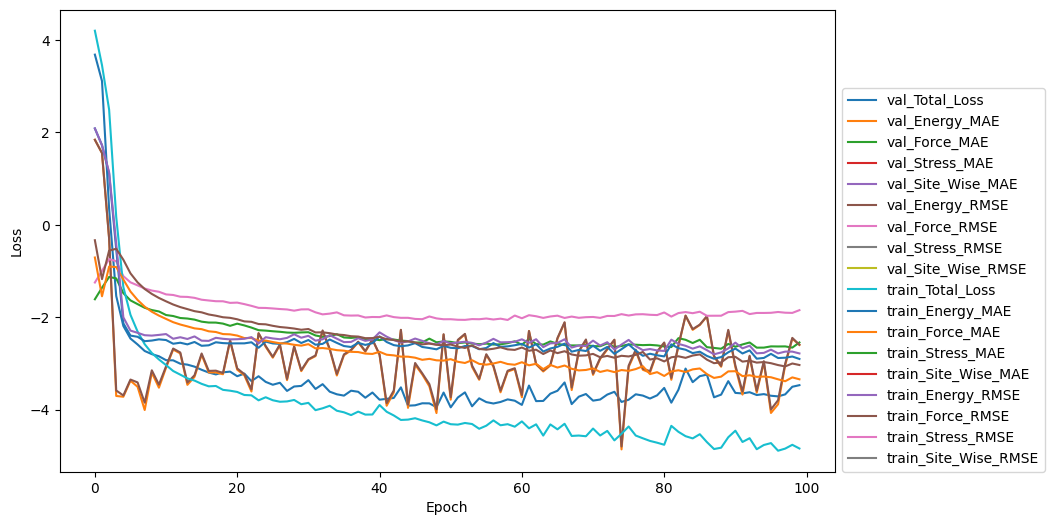

In [23]:
# Get the list of loss column names
loss_columns = [col for col in df.columns if col.startswith('val_') or col.startswith('train_')]

# Create a figure and axis
fig = plt.subplots(figsize=(10, 6))

# Plot each loss
for loss_column in loss_columns:
    plt.plot(df.index, np.log(df[loss_column]), label=loss_column)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=(1.01, 0))
plt.savefig(f'm3gnet_loss.eps', dpi=dpi, bbox_inches='tight')
plt.show()

In [15]:
df['val_Energy_MAE'].iloc[-1], df['val_Force_MAE'].iloc[-1], df['val_Stress_MAE'].iloc[-1]

(0.1096615195274353, 0.054066278040409, 0.0)

# Cleanup the notebook

In [ ]:
# This code just performs cleanup for this notebook from temporal files

patterns = ['dgl_graph*.bin', 'dgl_line_graph*.bin', 'state_attr*.pt', 'labels*.json']
for pattern in patterns:
    files = glob.glob(pattern)
    for file in files:
        try:
            os.remove(file)
        except FileNotFoundError:
            pass

#shutil.rmtree('logs')
#shutil.rmtree('trained_model')
#shutil.rmtree('finetuned_model')